# `solvekdv`: maths for constant bathymetry
Connor Duffin *The University of Western Australia*

The following document outlines the maths behind the finite difference KdV solver implemented in the `solvekdv` package. To set the scene, we begin with the governing equations. For the wave profile, $A$, we have:

\begin{equation}
   A_t + c A_x + \alpha A A_x + \beta A_{xxx} = 0.
\end{equation}

The coefficients $c$, $\alpha$, and $\beta$ are all determined from the eigenvalue problem:

\begin{equation}
  \phi''(z) + \frac{N^2(z)}{c^2} \phi(z) = 0,
\end{equation}

with boundary and normalization conditions ($z$ is taken to be from $0$ to $H$ at the ocean floor):

\begin{equation}
  \phi(0) = \phi(H) = 0
\end{equation}

\begin{equation}
  \max \phi = 1.
\end{equation}

The Brunt-Vaisala frequency, $N^2(z)$, is

\begin{equation}
  N^2 (z) = - \frac{g}{\rho_0} \frac{\mathrm d \bar \rho}{\mathrm d z}.
\end{equation}

These coefficients are given by:

\begin{align}
  \alpha &= \frac{3c}{2} \frac{\int (\phi'(z))^3 \mathrm d z}{\int (\phi'(z))^2 \mathrm d z}, \\
  \beta &= \frac{c}{2} \frac{\int \phi(z)^2\mathrm d z}{\int (\phi'(z))^2 \mathrm d z}
\end{align}

Under the assumptions that the flow is inviscid, incompressible, and nonrotating the above equations can be derived from the [Boussinesq approximation](https://en.wikipedia.org/wiki/Boussinesq_approximation_(water_waves)). I will refer to $\phi$ as the *vertical mode* from here on in (and in the code itself).

## Solving the system numerically

So we've got two problems to solve:

  1) The vertical mode eigenvalue problem.
  
  2) The KdV equation.
  
To solve the vertical mode eigenvalue problem, `solvekdv` uses a second-order accurate finite difference approximation to the second derivative, and then uses a standard eigenvalue algorithm to determine the vertical mode eigenfunction (approximated by the resultant eigenvector). We take the solution corresponding to the lowest eigenvalue, and use this to approximate the wave speed ($c$).

To solve the KdV equation we use the implicit-explicit solver of [Durran and Blossey](https://atmos.uw.edu/~durrand/pdfs/AMS/2012_Durran_Blossey_MWR.pdf). This is a finite difference scheme that is stable and fast. After computing the above coefficients it is not too difficult to implement.

### Numerically solving the vertical mode problem

We begin by introducing the following, standard finite difference notation. Discretize our $z$ grid into $n$ equally spaced values: $z = 0, \Delta z, 2 \Delta z, 3 \Delta z, \ldots, (n - 2) \Delta z, (n - 1) \Delta z = H$. Notice that the first element is given by $0$ and the last element of the sequence is given by the depth $H$. This allows us to represent the second derivative by approximation:

\begin{equation}
  \phi''(z) \approx \frac{\phi(z + \Delta z) - 2 \phi(z) + \phi(z - \Delta z)}{(\Delta z)^2}
\end{equation}

and on the grid points this gives:

\begin{equation}
  \phi_i '' \approx \frac{\phi_{i + 1} - 2 \phi_i + \phi_{i - 1}}{(\Delta z)^2}.
\end{equation}

We can represent $\phi$ on this grid, therefore, by the vector $(\phi_0, \phi_1, \ldots, \phi_n)$. Furthermore, as we can represent the finite difference approximation of the second derivative by the use of a *difference matrix*, the approximation to the eigenvalue problem becomes the eigenvector problem:

\begin{equation}
  \mathbf D \boldsymbol \phi = - \lambda \mathbf n \otimes \boldsymbol \phi
\end{equation}

Where the vector $\mathbf n$ is a vector of Brunt-Vaisala frequencies, computed for each $z = 0, \Delta z, \ldots, H$. In this formulation, we can derive the wave speed $c$ as $\lambda = 1 / c^2 \implies c = 1 / \sqrt{\lambda}$ (only take the positive root).

From the output of the eigendecomposition, we take the eigenvector as being an approximation to the vertical mode $\phi$, and use the eigenvalue to compute the approximation to the wave speed $c$. We compute a numerical approximation to the gradient $\phi'(z)$ using this eigenvector, and use a numerical quadrature scheme to get the values of $\alpha$ and $\beta$.

### Numerically solving the KdV equation

To numerically solve the KdV equation we use an implicit-explicit (IMEX) finite difference method. IMEX methods are useful because they allow for implicitly differencing the linear parts of the PDE and explicitly differencing the nonlinear parts of the PDE. The method that we will use in this paper is the so-called AM2-AX2 of [Durran and Blossey](https://atmos.uw.edu/~durrand/pdfs/AMS/2012_Durran_Blossey_MWR.pdf). This discretisation is as follows. Suppose that we have a PDE of the form:

\begin{equation}
  A_t = \mathcal L A + f(A),
\end{equation}

where $\mathcal L$ is a linear operator, and $f(\cdot)$ is some nonlinear operator. Let us then discretize with respect to time to give:

\begin{equation}
  \frac{A^{n + 1} - A^n}{\Delta t} 
  = \frac{7}{4} f(A^n) - f(A^{n - 1}) + \frac{1}{4} f(A^{n - 2})
  + \frac{3}{4} \mathcal L A^{n + 1} - \frac{1}{4} \mathcal L A^{n - 1}
\end{equation}

which after some rearranging gives:

\begin{equation}
  A^{n + 1} -\frac{3 \Delta t}{4} \mathcal L A^{n + 1}
  = A^n + \frac{7 \Delta t}{4} f(A^n) - f(A^{n - 1}) - \frac{\Delta t}{4} \mathcal L A^{n - 1}
  + \frac{\Delta t}{4} f(A^{n - 2}).
\end{equation}

For the KdV equation, we can write it in an equivalent form to give:

\begin{equation}
  A_t = - c A_x - \beta A_{xxx} - \alpha A A_x
\end{equation}

and so our IMEX equivalent form is:

\begin{equation}
  A^{n + 1} 
  + \frac{3 \Delta t}{4} \mathcal (c A_x^{n + 1} + \beta A_{xxx}^{n + 1})
  = A^n - \frac{7 \Delta t}{4} \alpha A^n A_x^n + \alpha A^{n - 1} A_x^{n - 1}
  + \frac{\Delta t}{4} \mathcal (c A_x^{n - 1} + \beta A_{xxx}^{n - 1})
  - \frac{\Delta t}{4} \alpha A^{n - 2} A_x^{n - 2}
\end{equation}

Represent all derivatives as their finite difference equivalents and, after some calculation, we arrive at the matrix equation for the update:

\begin{equation}
  \mathbf L \mathbf a^{n + 1} = \mathbf r,
\end{equation}

where $\mathbf L$ is the matrix version of the LHS, $\mathbf a$ is the approximation to the KdV solution, and $\mathbf r$ is the vector computed from the RHS. In each iteration this involves solving this large system of equations ($\mathcal O(10^3)$), which is efficiently done through the use of the `spsolve` (sparse-solve) function in Python.

## An example of how `solvekdv` works on a basic problem

Let's now go through an application of `solvekdv`, to see how all of the above is done in practice. Start with importing all of the required libaries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from solvekdv import kdv
from solvekdv import vert

Next, set-up and solve the vertical mode problem:

In [3]:
# solve the vertical mode problem
vertical = vert.VerticalMode(0.1, 0, 300, 1000)
vertical.compute_density("lamb-yan-1")
vertical.find_vertical_mode()
vertical.compute_r10()
vertical.compute_r01()
print(
    f"r10: {vertical.r10:.4f}\n"
    + f"r01: {vertical.r01:.4f}\n"
    + f"c:   {vertical.c:.4f}\n"
)

r10: -0.0166
r01: 2920.6500
c:   0.8427



The density is computed from the equation (1.1) from [Lamb and Yan](add). This is all the parameters that we need for the KdV equation. Next, initialize the solving routine by:

In [4]:
test = kdv.Kdv(
    dt=10, dx=50, start_x=-150000, end_x=150000, start_t=0, end_t=24 * 60**2
)

test.set_initial_condition(
    - 20 * (1/4) * ((1 + np.tanh((test.x_grid + 20000) / 2000))
    * (1 - np.tanh(test.x_grid / 2000)))
)

test.set_kdv_parameters(
    a=2 * vertical.r10 * vertical.c,
    b=vertical.r01,
    c=vertical.c
)

test.set_first_order_matrix()
test.set_third_order_matrix()
test.set_lhs_matrix()

Let's go through this piece by piece:

* First, we initialize a `kdv` class object, with stepsize 10 m in the $x$ direction and 50 seconds in time.
* We set our domain to be from $-150$ km to $150$ km, and our overall time window to be $24$ hours.
* We set our initial conditions to be a depression in the surface, with width 20 km.
* We then set the parameters, and initialize all of the matrices.

The initial condition looks like:

(-300, 5)

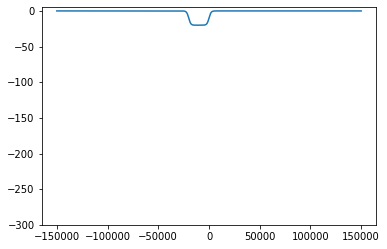

In [9]:
plt.plot(test.x_grid, test.u0)
plt.ylim((-300, 5))

Now, let's run the solver. This is pretty easy. All you need to do is run a loop, and in each iteration you run a `solve_step` on the `Kdv` object. This handles everything.

In [10]:
u = np.zeros([test.n_x, test.n_t])
for i in range(test.n_t):
    if (i % int(0.1 * test.n_t)) == 0:
        print(f"Simulation {100 * i / test.n_t:.1f} % complete.")
    u[:, i] = test.solve_step()


Simulation 0.0 % complete.
Simulation 10.0 % complete.
Simulation 20.0 % complete.
Simulation 30.0 % complete.
Simulation 40.0 % complete.
Simulation 50.0 % complete.
Simulation 60.0 % complete.
Simulation 70.0 % complete.
Simulation 80.0 % complete.
Simulation 90.0 % complete.


Now that we have our results, let's plot the final output. This gives us:

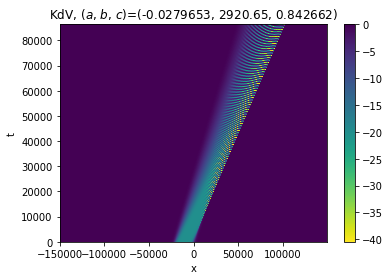

In [12]:
# plot results
xmesh, ymesh = np.meshgrid(test.x_grid, test.t_grid)
plt.figure()
plt.pcolormesh(xmesh, ymesh, u.T, cmap="viridis_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("t")
plt.title(
    "KdV, ($a$, $b$, $c$)=(%g, %g, %g)" % (test.a, test.b, test.c)
)
plt.show()

Finally, let's plot the KdV solution over a couple of time points, to get a feel for what the solutions are doing:

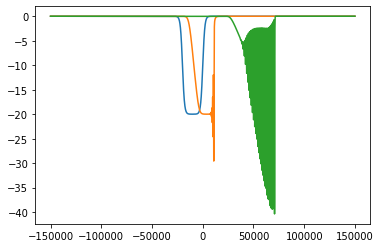

In [17]:
plt.plot(test.x_grid, u[:, 0])
plt.plot(test.x_grid, u[:, 1_000])
plt.plot(test.x_grid, u[:, 6_000])